## AI Vs Real Art Image Classification

The dataset comprises of two classes- art images generated by AI image generation models such as DALL-E and Midjourney, and real images known to be made by humans.
The objective of this project is to classify the images as AI or Real art using image classification techniques.
We have the Kaggle dataset (refer the readme for details) that consists of ~22k high quality images with the split of 18k AI generated and 4k real images.

Since I am running this on my machine, I will sample just 4k AI images for the purpose of training the model to work within the resource constraints. We will have a balanced dataset of both AI and real images with ~4k images of each.

We will try the following models for classification

1. A CNN architecture defined from scratch
2. Hyper-parameter tuning of the CNN architecture to improve the model above
3. A transfer learning approach using VGG16 where we will use it in three different ways
 -  Extract features using the weights of imagenet and then feed to fully connected layers
 -  Train the VGG16 architecture from scratch on our dataset
 -  Freeze some layers of the VGG16 architecture and train the test.

Overall, we are evaluating 5 models.


Since we are working on a balanced dataset, we will use __accuracy__ as the metric to evaluate the models.

### Data Pre-processing

In [42]:
# import necessary libraries and functions
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from os import listdir
import random
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')


In [2]:
class0_folder= 'dataset/fakeV2/fake-v2'
class1_folder= 'dataset/real'

In [3]:
print("No of AI generated images: ",len(os.listdir(class0_folder)))
print("No of Real images: ",len(os.listdir(class1_folder)))

No of AI generated images:  17856
No of Real images:  3781


I am sampling __4000__ images from the AI data folder simply to make the dataset manageable for several iterations of our deep learning model. The ideal way to tackle this problem would be to use the full dataset. In that case, we could do an image augmentation on the real images to make the dataset balanced again by generating more real images through augmentation techniques.



In [4]:
# Set the random seed for reproducibility
random.seed(42)
sampled_fake= random.sample(os.listdir(class0_folder),4000)


The images in the dataset are high quality images. I observed that I was getting the error **Image size exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.**

To take care of this, I am filtering out any image in our dataset which exceeds this pixel size.

In [5]:
# Define a function to filter out excessively large images
def filter_large_images(image_dir, max_pixels):
    filtered_images = []
    for filename in os.listdir(image_dir):
        filepath = os.path.join(image_dir, filename)
        try:
            with Image.open(filepath) as img:
                if img.size[0] * img.size[1] <= max_pixels:
                    continue
                    #filtered_images.append(filename)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            filtered_images.append(filename)
    return filtered_images

# Define your image directory and maximum allowable pixels

max_pixels = 178956970  #The model was giving error for pixel sizes above this value; so testing with this as threshold

# Filter out excessively large images from fake dataset
filtered_images_fake = filter_large_images(class0_folder, max_pixels)

# Filter out excessively large images from real dataset
filtered_images_real = filter_large_images(class1_folder, max_pixels)

Error processing .DS_Store: cannot identify image file 'dataset/fakeV2/fake-v2/.DS_Store'
Error processing 12479.jpg: Image size (232748750 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Error processing r-art.txt: cannot identify image file 'dataset/real/r-art.txt'


Let us keep an image size that works suitably for the models we have decided to work with. __224x224__ is the dimension and __32__ is the selected batch size.

In [6]:
target_size= (224,224)

batch_size= 32

We are going to create instances of the ImageDataGenerator class which is a powerful utility of Keras that helps handle image data and manage pre-processing (standardizing the pixels).

In [7]:
# Create ImageDataGenerator instances for train and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Function to load filenames and labels
def load_filenames_labels(folder, label, large_img, sampled_imgs=None):
    if sampled_imgs is None:
        sampled_imgs= os.listdir(folder)
    filenames = []
    labels = []
    for filename in os.listdir(folder):
        if (filename not in large_img) and (filename in sampled_imgs) :
            filenames.append(os.path.join(folder, filename))
            labels.append(label)
    return filenames, labels

# Load filenames and labels for Class 0
class0_filenames, class0_labels = load_filenames_labels(class0_folder, '0', filtered_images_fake, sampled_fake)

# Load filenames and labels for Class 1
class1_filenames, class1_labels = load_filenames_labels(class1_folder, '1', filtered_images_real )

Below is the list of all the files along with the class labels.

In [9]:
# Concatenate filenames and labels from both classes
all_filenames = class0_filenames + class1_filenames
all_labels = class0_labels + class1_labels

In [10]:
len(all_filenames), len(all_labels)

(7780, 7780)

We have a balanced class thanks to the sampling we applied. But we also can make sure this balance is maintained in the validation set by using a stratified train-test split with stratification by the labels. This will ensure we have a truly balanced dataset in both train and validation set.


In [11]:
# Split the data into train and validation sets while maintaining class balance
train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

In [12]:
# Create the generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_filenames, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 6224 validated image filenames belonging to 2 classes.


In [13]:
# Create the generator for validation data
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': validation_filenames, 'class': validation_labels}),
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 1556 validated image filenames belonging to 2 classes.


In [14]:
train_data_shape = train_generator.image_shape
validation_data_shape = validation_generator.image_shape

print("Shape of training data:", train_data_shape)
print("Shape of validation data:", validation_data_shape)

Shape of training data: (224, 224, 3)
Shape of validation data: (224, 224, 3)


## Model Building

### 1. CNN from scratch

In [19]:
#defining the model architecture
name="Basic_CNN"

model= Sequential()

#defining input layer with 3D input of shape (224,224,3)
model.add(InputLayer(input_shape=(224,224,3)))


#defining the first convolutional layer with 25 filters of size (5,5)
model.add(Conv2D(25, (5,5), activation='relu', strides= (1,1), padding= 'valid'))
#defining the second convolutional layer with 50 filters of size (5,5)
model.add(Conv2D(50, (5,5), activation='relu', strides= (1,1), padding= 'valid'))

#flattening the output from convolutional layers so that it can be forwarded to the dense layers
model.add(Flatten())

#defining the first dense or fully connected layer with 100 neurons
model.add(Dense(units=100, activation='sigmoid'))

#defining the output layer with 1 neuron since it is a binary classificaion problem
model.add(Dense(units=1, activation= 'sigmoid'))

# Compile the model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 220, 25)      1900      
                                                                 
 conv2d_7 (Conv2D)           (None, 216, 216, 50)      31300     
                                                                 
 flatten_3 (Flatten)         (None, 2332800)           0         
                                                                 
 dense_6 (Dense)             (None, 100)               233280100 
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 233313401 (890.02 MB)
Trainable params: 233313401 (890.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
filepath= os.path.join("models",f"{name}.hdf5")
checkpoint= ModelCheckpoint(filepath=filepath, monitor="val_accuracy",verbose=1, save_best_only=True, mode='max')

# Fit the model to the training data and validate on the validation data
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,  
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator), callbacks=[checkpoint])

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.6040
Epoch 1: val_accuracy improved from -inf to 0.66774, saving model to models/Basic_CNN.hdf5
195/195 [==============================] - 138s 704ms/step - loss: 0.6743 - accuracy: 0.6040 - val_loss: 0.6206 - val_accuracy: 0.6677
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.6637
Epoch 2: val_accuracy improved from 0.66774 to 0.68380, saving model to models/Basic_CNN.hdf5
195/195 [==============================] - 137s 704ms/step - loss: 0.6323 - accuracy: 0.6637 - val_loss: 0.6095 - val_accuracy: 0.6838
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.6857
Epoch 3: val_accuracy did not improve from 0.68380
195/195 [==============================] - 138s 706ms/step - loss: 0.6099 - accuracy: 0.6857 - val_loss: 0.5998 - val_accuracy: 0.6819
Epoch 4/10
195/195 [==============================] - ETA: 0s - loss: 0

In [21]:
model.load_weights(filepath=filepath)
predictions= model.predict(validation_generator)

predicted_labels = (predictions > 0.5).astype(int)
true_labels= validation_generator.classes

# Print the classification report
print(classification_report(true_labels, predicted_labels))

49/49 [==============================] - 29s 589ms/step
              precision    recall  f1-score   support

           0       0.67      0.85      0.75       800
           1       0.78      0.56      0.65       756

    accuracy                           0.71      1556
   macro avg       0.73      0.70      0.70      1556
weighted avg       0.72      0.71      0.70      1556



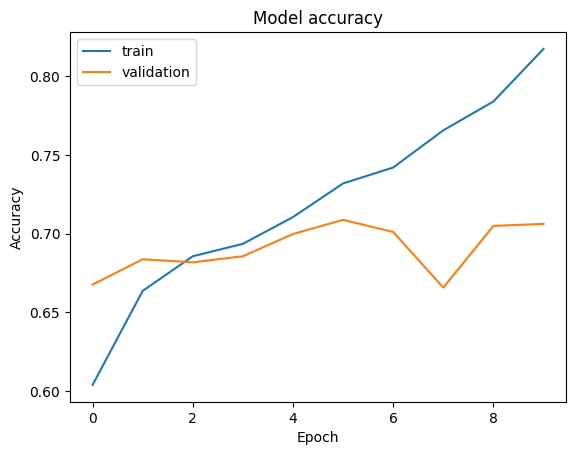

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We have run this network only for 10 epochs, but as can be seen, the model has started overfitting after around 5 epochs.

Let us try a network with one more convolutional layer, but we will add a maxpool layers as well. 

## 2. CNN with parameter tuning

In [23]:
name= "CNN_with_tuning"
model= Sequential()

#defining input layer with 3D input of shape (224,224,3)
model.add(InputLayer(input_shape=(224,224,3)))


#defining the first convolutional layer with 25 filters of size (5,5)
model.add(Conv2D(25, (5,5), activation='relu', strides= (1,1), padding= 'valid'))
#defining the second convolutional layer with 50 filters of size (5,5)
model.add(Conv2D(50, (5,5), activation='relu', strides= (1,1), padding= 'valid'))
#defining the second convolutional layer with 50 filters of size (5,5)
model.add(Conv2D(50, (5,5), activation='relu', strides= (1,1), padding= 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

#flattening the output from convolutional layers so that it can be forwarded to the dense layers
model.add(Flatten())

#defining the first dense or fully connected layer with 100 neurons
model.add(Dense(units=100, activation='sigmoid'))
#defining the output layer with 1 neuron since it is a binary classificaion problem
model.add(Dense(units=1, activation= 'sigmoid'))

adam= Adam(learning_rate=1e-5)
# Compile the model
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 25)      1900      
                                                                 
 conv2d_9 (Conv2D)           (None, 216, 216, 50)      31300     
                                                                 
 conv2d_10 (Conv2D)          (None, 212, 212, 50)      62550     
                                                                 
 max_pooling2d (MaxPooling2  (None, 106, 106, 50)      0         
 D)                                                              
                                                                 
 flatten_4 (Flatten)         (None, 561800)            0         
                                                                 
 dense_8 (Dense)             (None, 100)               56180100  
                                                      

In [24]:
filepath= os.path.join("models",f"{name}.hdf5")
checkpoint= ModelCheckpoint(filepath=filepath, monitor="val_accuracy",verbose=1, save_best_only=True, mode='max')

# Fit the model to the training data and validate on the validation data
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,  
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator), callbacks=[checkpoint])

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.6292 - accuracy: 0.6814
Epoch 1: val_accuracy improved from -inf to 0.71658, saving model to models/CNN_with_tuning.hdf5
195/195 [==============================] - 170s 871ms/step - loss: 0.6292 - accuracy: 0.6814 - val_loss: 0.5922 - val_accuracy: 0.7166
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.7273
Epoch 2: val_accuracy did not improve from 0.71658
195/195 [==============================] - 169s 863ms/step - loss: 0.5828 - accuracy: 0.7273 - val_loss: 0.5748 - val_accuracy: 0.7082
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.7433
Epoch 3: val_accuracy improved from 0.71658 to 0.72815, saving model to models/CNN_with_tuning.hdf5
195/195 [==============================] - 170s 868ms/step - loss: 0.5426 - accuracy: 0.7433 - val_loss: 0.5505 - val_accuracy: 0.7281
Epoch 4/10
195/195 [==============================] - ETA: 

In [25]:
model.load_weights(filepath=filepath)
predictions= model.predict(validation_generator)

predicted_labels = (predictions > 0.5).astype(int)
true_labels= validation_generator.classes

# Print the classification report
print(classification_report(true_labels, predicted_labels))

49/49 [==============================] - 29s 587ms/step
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       800
           1       0.78      0.70      0.74       756

    accuracy                           0.76      1556
   macro avg       0.76      0.76      0.76      1556
weighted avg       0.76      0.76      0.76      1556



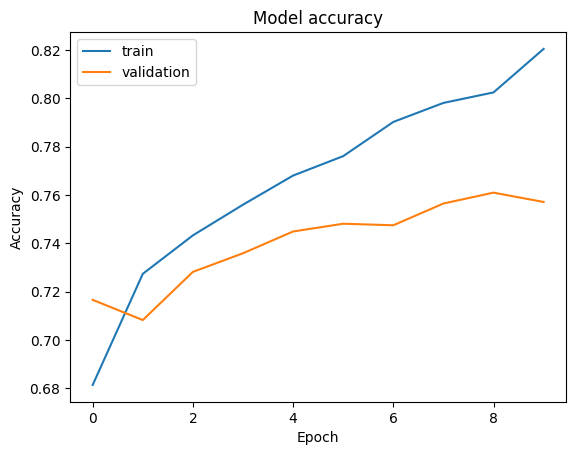

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The above model has been a significant improvement upon our initial model, but we can see the model starting to overfit.

### Transfer learning using VGG16

### 1. Feature extraction from Imagenet weights followed by fully connected layers

In [27]:
# Load the pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create ImageDataGenerator instances for train and validation sets along with the preprocessing for VGG16
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [28]:
# Split the data into train and validation sets while maintaining class balance
train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Create the generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_filenames, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# Create the generator for validation data
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': validation_filenames, 'class': validation_labels}),
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)


Found 6224 validated image filenames belonging to 2 classes.
Found 1556 validated image filenames belonging to 2 classes.


In [29]:
# Extract features using VGG16
train_features = base_model.predict(train_generator)
validation_features = base_model.predict(validation_generator)

# Reshape features
train_features = np.reshape(train_features, (train_features.shape[0], -1))
validation_features = np.reshape(validation_features, (validation_features.shape[0], -1))

# Normalize features to [0, 1]
train_features /= np.max(train_features)
validation_features /= np.max(validation_features)

train_features.shape, validation_features.shape

49/49 [==============================] - 30s 614ms/step


((6224, 25088), (1556, 25088))

In [30]:
# Get the labels from the generators and make it categorical
train_labels = to_categorical(train_generator.classes)
validation_labels = to_categorical(validation_generator.classes)

In [31]:
#adding the sequential model

name= 'VGG16_imagenet_weights'
model = Sequential()
#input the 25088 features extracted from the VGG16 to the fully connected layers
model.add(InputLayer((25088, )))
# add fully connected layer with 1024 neurons and relu activation
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer with dropout rate of 0.5
# add fully connected layer with 2 neurons and relu activation
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 12846594 (49.01 MB)
Trainable params: 12846594 (49.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
filepath= os.path.join("models",f"{name}.hdf5")
checkpoint= ModelCheckpoint(filepath=filepath, monitor="val_accuracy",verbose=1, save_best_only=True, mode='max')

# Fit the model to the training data and validate on the validation data
history = model.fit(train_features, train_labels, 
                    epochs=15, 
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels), 
                    callbacks=[checkpoint])

Epoch 1/15
194/195 [============================>.] - ETA: 0s - loss: 0.6399 - accuracy: 0.6517
Epoch 1: val_accuracy improved from -inf to 0.75900, saving model to models/VGG16_imagenet_weights.hdf5
195/195 [==============================] - 3s 13ms/step - loss: 0.6397 - accuracy: 0.6523 - val_loss: 0.5857 - val_accuracy: 0.7590
Epoch 2/15
195/195 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.7518
Epoch 2: val_accuracy improved from 0.75900 to 0.77442, saving model to models/VGG16_imagenet_weights.hdf5
195/195 [==============================] - 2s 12ms/step - loss: 0.5591 - accuracy: 0.7518 - val_loss: 0.5286 - val_accuracy: 0.7744
Epoch 3/15
191/195 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.7777
Epoch 3: val_accuracy improved from 0.77442 to 0.78342, saving model to models/VGG16_imagenet_weights.hdf5
195/195 [==============================] - 2s 12ms/step - loss: 0.5092 - accuracy: 0.7768 - val_loss: 0.4949 - val_accuracy: 0.783

In [33]:
model.load_weights(filepath=filepath)
predictions= model.predict(validation_features)

predicted_labels = (predictions > 0.5).astype(int)
true_labels= validation_labels

# Print the classification report
print(classification_report(true_labels, predicted_labels))

49/49 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       800
           1       0.85      0.81      0.83       756

   micro avg       0.84      0.84      0.84      1556
   macro avg       0.84      0.84      0.84      1556
weighted avg       0.84      0.84      0.84      1556
 samples avg       0.84      0.84      0.84      1556



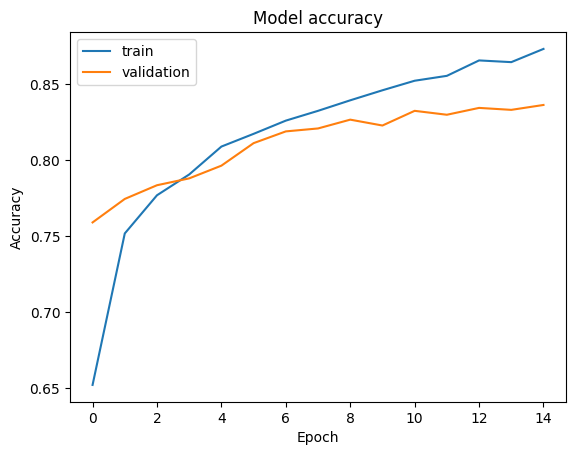

In [34]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

VGG16 with features generated perform significantly better than the CNN architecture we defined.

### 2. Training the architecture from scratch


In [35]:
# Create ImageDataGenerator instances for train and validation sets along with the preprocessing for VGG16
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

# Split the data into train and validation sets while maintaining class balance
train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(
    all_filenames, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Create the generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_filenames, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Create the generator for validation data
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': validation_filenames, 'class': validation_labels}),
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Found 6224 validated image filenames belonging to 2 classes.
Found 1556 validated image filenames belonging to 2 classes.


In [36]:
# creating model with pre trained imagenet weights
base_model = VGG16(weights='imagenet')

#shows model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
#creating our own model using a functional approach
name= 'VGG16_trained'
x= Dense(256, activation= 'relu', name= 'fully-connected')(base_model.layers[-4].output) #Take output from the flatten layer of base model
y= Dense(2, activation= 'softmax', name= 'prediction')(x)

model= Model(base_model.input,y)
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
filepath= os.path.join("models",f"{name}.hdf5")
checkpoint= ModelCheckpoint(filepath=filepath, monitor="val_accuracy",verbose=1, save_best_only=True, mode='max')

# Fit the model to the training data and validate on the validation data
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[checkpoint])

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.7956
Epoch 1: val_accuracy improved from -inf to 0.85668, saving model to models/VGG16_trained.hdf5
195/195 [==============================] - 170s 867ms/step - loss: 0.4261 - accuracy: 0.7956 - val_loss: 0.3170 - val_accuracy: 0.8567
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9010
Epoch 2: val_accuracy improved from 0.85668 to 0.88303, saving model to models/VGG16_trained.hdf5
195/195 [==============================] - 169s 866ms/step - loss: 0.2433 - accuracy: 0.9010 - val_loss: 0.3113 - val_accuracy: 0.8830
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9494
Epoch 3: val_accuracy improved from 0.88303 to 0.89974, saving model to models/VGG16_trained.hdf5
195/195 [==============================] - 170s 866ms/step - loss: 0.1372 - accuracy: 0.9494 - val_loss: 0.2599 - val_accuracy: 0.8997
Epoch 4/10
195/1

In [39]:
model.load_weights(filepath=filepath)
predictions= model.predict(validation_generator)

predicted_labels =  np.argmax(predictions, axis=1).astype('str')
true_labels= validation_labels

# Print the classification report
print(classification_report(true_labels, predicted_labels))

49/49 [==============================] - 29s 586ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       800
           1       0.92      0.88      0.90       756

    accuracy                           0.91      1556
   macro avg       0.91      0.91      0.91      1556
weighted avg       0.91      0.91      0.91      1556



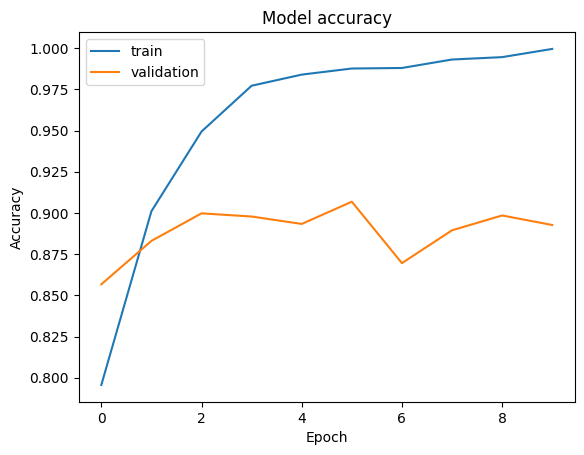

In [40]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The above has significant overfitting issues. Maybe we could freeze some layers and then train the rest while also adding some regularization on the fully connected layers at the top.

### 3. Freezing the bottom layers and training the top layers


In [41]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
# creating our own model
name= 'VGG16_partially_trained'
x1 = Dense(256, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(base_model.layers[-4].output)
x2= Dropout(0.5,name= 'dropout')(x1)
y = Dense(2, activation='softmax', name='prediction')(x2)
model = Model(base_model.input, y)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
len(model.layers)

23

In [45]:
# to set the first 15 layers to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False 

In [46]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [47]:
filepath= os.path.join("models",f"{name}.hdf5")
checkpoint= ModelCheckpoint(filepath=filepath, monitor="val_accuracy",verbose=1, save_best_only=True, mode='max')

# Fit the model to the training data and validate on the validation data
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=[checkpoint])

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 5.3905 - accuracy: 0.8356
Epoch 1: val_accuracy improved from -inf to 0.88946, saving model to models/VGG16_partially_trained.hdf5
195/195 [==============================] - 139s 708ms/step - loss: 5.3905 - accuracy: 0.8356 - val_loss: 5.0675 - val_accuracy: 0.8895
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 4.7358 - accuracy: 0.9523
Epoch 2: val_accuracy did not improve from 0.88946
195/195 [==============================] - 140s 717ms/step - loss: 4.7358 - accuracy: 0.9523 - val_loss: 4.7660 - val_accuracy: 0.8882
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 4.3490 - accuracy: 0.9873
Epoch 3: val_accuracy improved from 0.88946 to 0.89332, saving model to models/VGG16_partially_trained.hdf5
195/195 [==============================] - 140s 717ms/step - loss: 4.3490 - accuracy: 0.9873 - val_loss: 4.5029 - val_accuracy: 0.8933
Epoch 4/10
195/195 [=======================

In [48]:
model.load_weights(filepath=filepath)
predictions= model.predict(validation_generator)

predicted_labels =  np.argmax(predictions, axis=1).astype('str')
true_labels= validation_labels

# Print the classification report
print(classification_report(true_labels, predicted_labels))

49/49 [==============================] - 29s 600ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       800
           1       0.90      0.90      0.90       756

    accuracy                           0.90      1556
   macro avg       0.90      0.90      0.90      1556
weighted avg       0.90      0.90      0.90      1556



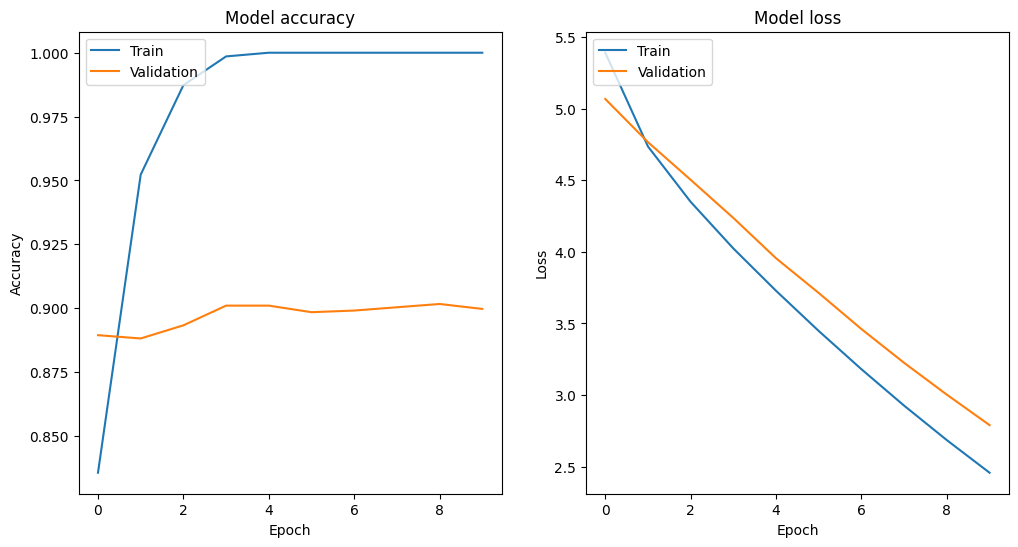

In [49]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training & validation accuracy values
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)

Again, this model is overfitting. We are still capped at 89-90% accuracy across both labels. But it is interesting to note that the loss is consistently going down. So it could be that there are certain instances where the VGG16 architecture struggles to generalize. The loss is going down by virtue of the loss of correctly classified instances going down.

Below is a summary of the results

| Model | Accuracy|
|---|---|
|Basic CNN | 71%|
|CNN with parameter tuning| 76%|
|VGG16 with imagenet weights| 84%|
|**VGG16 fully trained on this data**| **91%**|
|VGG16 partially trained on this data|90%|

Some of these models still show overfitting. Following are approaches I would take to further improve this.

- **Data augmentation**- We have 17k images of AI art and 4k images of real art. One method to improve upon overfitting is to feed more data to the model. We could do augmentation on the real art and create a larger training set.
- **Image De-noising**- We could feed the model through a denoising process and see if it enhances the quality of prediction.
- **Different architectures**- Try other architectures like efficientnet.
